In [2]:
!pip install underthesea

     |████████████████████████████████| 7.5MB 8.8MB/s 
     |████████████████████████████████| 747kB 44.2MB/s 
     |████████████████████████████████| 753.2MB 22kB/s 
     |████████████████████████████████| 1.3MB 45.6MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 245kB 56.6MB/s 
     |████████████████████████████████| 890kB 58.2MB/s 
     |████████████████████████████████| 2.9MB 60.7MB/s 
     |████████████████████████████████| 1.1MB 52.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=941416426e6195bbb387c532bd749d2333adccf7d6c10c414216d372942b2198
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=1d773bec12eb9e00943421f4158e2f2a3e90a4ebf1d37ba0d1a8a1bde68e0d41
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
import underthesea

In [4]:
def load_data_from_file(path, is_train=True):
  cmt = []
  cmts = []
  labels = []

  check = "train_"
  if is_train == False:
    check = "test_"
  with open(path, 'r', encoding="utf-8") as file:
    for line in file:
      if check in line:
        continue
      if len(line)>2:
        cmt.append(line)
      elif len(line)==2:
        if (line=="0\n" or line=="1\n"):
          labels.append(line.replace("\n", ""))
          cmts.append(" ".join(cmt).replace("\n", ""))
          cmt = []
  return cmts, labels

In [5]:
X_data, Y_data = load_data_from_file("/content/drive/MyDrive/Untitled_folder/SA_demo/train.crash")

In [6]:
def text_lowercase(text):
  return text.lower()
def remove_number(text):
  result = re.sub(r'\d+', '', text) 
  return result
def remove_punctuation(text):
  text = text.replace(",", " ").replace(".", " ") \
  .replace(";", " ").replace("“", " ") \
  .replace(":", " ").replace("”", " ") \
  .replace('"', " ").replace("'", " ") \
  .replace("!", " ").replace("?", " ") \
  .replace("-", " ").replace("?", " ") \
  .replace('"', " ")
  return text
def remove_whitespace(text): 
  return  " ".join(text.split())
def remove_similarletter(text):
  text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
  return text
def VN_Tokenize(text,format='text'):
  return underthesea.word_tokenize(text)
def remove_VN_stopwords(text):
  file_stopwords = pd.read_csv("/content/vietnamese-stopwords-dash.txt", encoding = 'UTF-8')
  file_stopwords.columns = ["Stop_words"]

  VN_stopword = []
  for i in file_stopwords["Stop_words"]:
    VN_stopword.append(i)
        
  text_token = VN_Tokenize(text)
  result = [word for word in text_token if word not in VN_stopword]
  return " ".join(result)
def Util(text):
    replace_list = {
        'sp': 'sản phẩm', 'san pham': 'sản phẩm', 'k': 'không', 'ko': 'không', 'khong': 'không', 'ok': 'tốt', 'dc': 'được', 'đc': 'được', 'đk': 'được', 'm': 'mình', 'mik': 'mình',
        'toẹt': 'tuyệt', 'cám ơn': 'cảm ơn', 'thanks': 'cảm ơn', 'tks': 'cảm ơn', 'ship': 'giao hàng', 'shop': 'cửa hàng', 'sop': 'cửa hàng', 'sd': 'sử dụng', 'tl': 'trả lời',
        'lém': 'lắm','sale': 'giảm giá','tt': 'thanh toán','yc': 'yêu cầu','đt': 'điện thoại', 'qc': 'quảng cáo', 'kq': 'kết quả', 'update': 'cập nhật', 'ns': 'nói', 'rep': 'trả lời',
        'tn': 'tin nhắn', 'wa': 'quá', 'wá': 'quá', 'hag': 'hàng', 'hàg': 'hàng','kt': 'kiểm tra', 'bit': 'biết', 'trc': 'trước', 'mn': 'mọi người', 'sz': 'kích thước', 
        'size': 'kích thước', 'kh': 'khách hàng', 'nv': 'nhân viên', 
        'T^T': 'negative',  ':((': 'negative', '❤️': 'positive', '😘': 'positive', '<3': 'positive', '😋': 'positive', '💋': 'positive', '🎉': 'positive', '💯': 'positive',
        '👍🏻': 'positive', '😡': 'negative', '😁': 'positive', '😍': 'positive', '💕': 'positive', '💙': 'positive', '😗': 'positive', '👌🏻': 'positive', '🤙🏻': 'positive',
        '👎': 'negative', '😓': 'negative', '♥️': 'positive'
    }
    text = text.split()
    len_ = len(text)
    for i in range(0, len_):    
      for k, v in replace_list.items():
        if (text[i]==k):
          text[i] = v
    return " ".join(text)

In [7]:
def Text_PreProcessing_util(data):
  result_2 = []
  for i in data:
    i = str(i)
    text = text_lowercase(i)
    text=Util(text)
    text = remove_similarletter(text)
    text = remove_number(text)
    text = remove_punctuation(text)
    text = remove_whitespace(text)
    text = remove_VN_stopwords(text)
    result_2.append(text)
  return result_2

In [42]:
X_data = Text_PreProcessing_util(X_data)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
vectorizer_2 = TfidfVectorizer(max_df=0.5)
vectorizer_2.fit(X_data)
X_data_tfidf = vectorizer_2.transform(X_data).toarray()

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
Y_data = [int(i) for i in Y_data]

In [14]:
X_train, X_test_1, y_train, y_test_1 = train_test_split(X_data_tfidf, Y_data, test_size=0.2)

In [15]:
model_4 = LogisticRegression()
model_4.fit(X_train, y_train)
print("Model Logistic Regression")
print("Train score: ", model_4.score(X_train, y_train))
print("Test score: ", model_4.score(X_test_1, y_test_1))

Model Logistic Regression
Train score:  0.9031004740073044
Test score:  0.8694841516469857


In [16]:
y_pred_1 = model_4.predict(X_test_1)

Confusion matrix, without normalization
[[1573  265]
 [ 155 1225]]


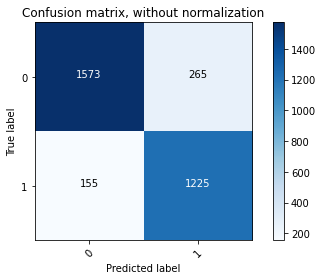

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
  
cnf_matrix = confusion_matrix(y_test_1, y_pred_1, labels=[0, 1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, without normalization')

In [18]:
from sklearn.metrics import f1_score
print("F1 score",f1_score(y_test_1, y_pred_1, average = 'macro'))

F1 score 0.8679397562343543


In [19]:
from sklearn.naive_bayes import MultinomialNB
model_5 = MultinomialNB()
model_5.fit(X_train, y_train)
print("Model Naive Bayes")
print("Train score: ", model_5.score(X_train, y_train))
print("Test score: ", model_5.score(X_test_1, y_test_1))

Model Naive Bayes
Train score:  0.882741471753827
Test score:  0.843691733996271


In [20]:
y_pred_2 = model_5.predict(X_test_1)

Confusion matrix, without normalization
[[1599  239]
 [ 264 1116]]


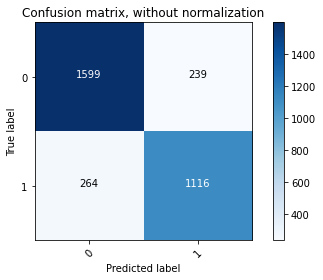

In [21]:
cnf_matrix_2 = confusion_matrix(y_test_1, y_pred_2, labels=[0, 1])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_2, classes=[0, 1],
                      title='Confusion matrix, without normalization')

In [22]:
print("F1 score",f1_score(y_test_1, y_pred_2, average = 'macro'))

F1 score 0.8400892688225475


In [23]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

In [43]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_data, Y_data, test_size=0.2)

In [44]:
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(X_data)

X_train_2 = tokenizer.texts_to_sequences(X_train_2)
X_test_2 = tokenizer.texts_to_sequences(X_test_2)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train_2 = pad_sequences(X_train_2, padding='post', maxlen=maxlen)
X_test_2 = pad_sequences(X_test_2, padding='post', maxlen=maxlen)
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/Untitled_folder/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [45]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
output1 = Dense(1, activation='tanh')(LSTM_Layer_1)

model = Model(inputs=deep_inputs, outputs=output1)

model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['acc'])

In [46]:
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 200, 100)          750200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 867,577
Trainable params: 117,377
Non-trainable params: 750,200
_________________________________________________________________
None


In [47]:
y_train_2 = np.array(y_train_2)

In [48]:
history = model.fit(X_train_2, y_train_2, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
322/322 [==============================] - 59s 178ms/step - loss: 2.4396 - acc: 0.5767 - val_loss: 0.6853 - val_acc: 0.5719
Epoch 2/10
322/322 [==============================] - 55s 172ms/step - loss: 0.6817 - acc: 0.5803 - val_loss: 0.6842 - val_acc: 0.5719
Epoch 3/10
322/322 [==============================] - 56s 175ms/step - loss: 0.6817 - acc: 0.5786 - val_loss: 0.6834 - val_acc: 0.5719
Epoch 4/10
322/322 [==============================] - 56s 175ms/step - loss: 0.6830 - acc: 0.5745 - val_loss: 0.6831 - val_acc: 0.5719
Epoch 5/10
322/322 [==============================] - 56s 174ms/step - loss: 0.6802 - acc: 0.5831 - val_loss: 0.6829 - val_acc: 0.5719
Epoch 6/10
322/322 [==============================] - 57s 176ms/step - loss: 0.6800 - acc: 0.5824 - val_loss: 0.6829 - val_acc: 0.5719
Epoch 7/10
322/322 [==============================] - 57s 176ms/step - loss: 0.6806 - acc: 0.5822 - val_loss: 0.6850 - val_acc: 0.5719
Epoch 8/10
322/322 [==============================] - 5

In [49]:
y_test_2 = np.array(y_test_2)

In [50]:
score = model.evaluate(X_test_2, y_test_2, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

101/101 [==============================] - 5s 50ms/step - loss: 0.6814 - acc: 0.5777
Test Score: 0.6814204454421997
Test Accuracy: 0.5776879787445068
